In [1]:
import re
import os
import os
import re

import matplotlib.pyplot as plt
import pandas as pd

from utils.evaluations_utils import *
import numpy as np
# % matplotlib inline
import matplotlib
import seaborn as sns
from create_entropy_estimation import EntropyEstimation
import re
from typing import List, Iterable, Dict

AVARAGE_RATE_ROUND_FACTOR = 1

plt.rcParams['figure.figsize'] = [10, 5]


recurstion old ,  3000
recurstion old ,  1000000
start job
start job


In [2]:


def binary_ent(l, n):
    p = l / n
    return -((1 - p) * np.log2(1 - p) + (p) * np.log2(p))


def binomial_ent(l, n):
    p = l / n
    return (1. / 2.) * np.log(2 * np.pi * np.exp(1) * n * p * (1 - p)) / n


file_name_regex = re.compile('(ID_[0-9]+_[0-9]+)')


class CTWHandler():

    def __init__(self):
        self.__data = dict()

    def add_data(self, path: Iterable[str]):
        # data:List[cee.EntropyEstimation]=[]
        for i in path:
            data = EntropyEstimation.load(i)
            if data.tag not in self.__data:
                self.__data[data.tag] = dict()
            if data.file_name not in self.__data[data.tag]:
                self.__data[data.tag][data.file_name] = dict()
            self.__data[data.tag][data.file_name][data.file_index] = data

    def get_item_by_file_name_and_index(self, f_name, index):
        return {k: v[f_name][index] for k, v in self.__data.items()}

    def __len__(self):
        conter = 0
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                conter += len(vf)
        return conter

    def get_next_data(self):
        data_list = []
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                for ki, vi in vf.items():
                    data_list.append(vi)  #,tree=vi.tree)
        return data_list

    def __iter__(self):
        for kt, vt in self.__data.items():
            for kf, vf in vt.items():
                for ki, vi in vf.items():
                    yield dict(tag=kt, file=kf, entropy=vi.entropy, rate=1000. * np.sum(vi.s) / vi.s.size,
                               n_spikes=np.sum(vi.s), l_segemnt=vi.s.size)  #,,tree=vi.tree)

    def to_df(self, tag_regex_to_remove: str | List[str] = '', normelize_entropy=True,
              group_dict: Dict[str, str] | None = None):
        key_data_arr = dict(full_tag=[], tag=[], file=[], entropy=[], rate=[],
                            n_spikes=[], group=[], l_segemnt=[])  #, normalized_entropy=[])
        if isinstance(tag_regex_to_remove, str):
            tag_regex_to_remove = [tag_regex_to_remove]
        if group_dict is not None:
            group_dict = {k: re.compile(f'{v}') for k, v in group_dict.items()}
        for kv in self:
            for k, v in kv.items():
                if k == 'tag':
                    disp_v = v
                    for i in tag_regex_to_remove:
                        disp_v = re.sub(i, '', disp_v)
                    disp_v = re.sub('([0-9]+-[0-9]+)',
                                    lambda x: x.group(1).replace('-', '.') if x.group(1) is not None else None,
                                    disp_v)  # replacing to decimal point
                    key_data_arr['tag'].append(disp_v)
                    if group_dict is not None:
                        unique_flag = None
                        empty_flag = False
                        v_groups_data_for_warning = []
                        for k_group, v_group in group_dict.items():
                            if v_group.match(v):
                                v_groups_data_for_warning.append((v, v_group))
                                key_data_arr['group'].append(k_group)
                                if unique_flag is None:
                                    unique_flag = True
                                else:
                                    unique_flag = False
                                empty_flag = True
                        assert unique_flag is None or unique_flag, 'Keys of group are not unique ' + ' and '.join(
                            v_groups_data_for_warning)
                        assert empty_flag, 'one key has no group ' + v
                    else:
                        key_data_arr['group'].append('')
                    key_data_arr['full_tag'].append(v)
                elif k == 'file':
                    v = file_name_regex.match(v).group(1)
                    key_data_arr[k].append(v)
                else:
                    key_data_arr[k].append(v)
        df = pd.DataFrame(data=key_data_arr)
        # df['sim_id']=df['file']+'@'+df['sim_index']
        # df.drop(columns=['file','sim_index'],inplace=True)

        return df

    def add_min_isi(self):

        data_arr = self.get_next_data()
        min_isi = {k: None for k in self.__data.keys()}
        for i in data_arr:
            indexes = np.where(i.s == 1)[0]
            print(indexes)
            cur_min_isi = np.min(indexes[1:] - indexes[:-1] - 1)
            if min_isi[i.tag] is None:
                min_isi[i.tag] = cur_min_isi
            elif min_isi[i.tag] > cur_min_isi:
                min_isi[i.tag] = cur_min_isi
        return min_isi

    def add_normalized(self, df, compress_to_minimal=False):
        tags = df['full_tag']

        if compress_to_minimal:
            min_isi_dict = self.add_min_isi()
            min_isi = np.array([min_isi_dict[t] for t in tags])
            print(f'min isi = {min_isi_dict}')
            df['normalizing_factor'] = binary_ent(df['n_spikes'], df['l_segemnt'] - (df['n_spikes'] * min_isi))
        else:
            df['normalizing_factor'] = binary_ent(df['n_spikes'], df['l_segemnt'])
        df['normalized_entropy'] = df['entropy'] / df['normalizing_factor']


In [3]:
#set params for handler
models = {}
regex_match = re.compile('Rat.+CTW')
#regex_match = re.compile('test')
gmax_regex = re.compile('.*_([0-9](?:-[0-9])?(?:_noNMDA)?)_.*')
gmax_value_regex = re.compile('([0-9](?:\.[0-9])?)[a-z,A-Z]*')
models_pathes = []
for i in os.listdir('entropy_data'):

    cur_dir_path = os.path.join('entropy_data', i)
    if regex_match.match(i) and os.path.isdir(cur_dir_path):
        for j in os.listdir(cur_dir_path):
            models_pathes.append(os.path.join(cur_dir_path, j))

name_order = list(models.values())
name_order = sorted(name_order, key=lambda x: (float(gmax_value_regex.match(x).group(0)), 'AMPA' not in x))

remove_v = True

In [4]:

c = CTWHandler()
c.add_data(models_pathes)
df = c.to_df(
    tag_regex_to_remove=['Rat_L5b_PC_2_Hay_', '(?:_noNMDA_CTW)', 'noNMDA_', '_CTW', 'current_injection_synapses_'],
    group_dict={'NMDA': 'Rat_L5b_PC_2_Hay_(?:[0-9]-)?[0-9]_CTW',
                'AMPA': 'Rat_L5b_PC_2_Hay_(?:noNMDA_(?:[0-9]-)?[0-9]|(?:[0-9]-)?[0-9]_noNMDA)_CTW',
                'Current Synapse': 'Rat_L5b_PC_2_Hay_current_injection_synapses_(?:[0-9]-)?[0-9]_CTW',
                'Current Synapse AMPA': 'Rat_L5b_PC_2_Hay_current_injection_synapses_noNMDA_(?:[0-9]-)?[0-9]_CTW'}, )
for i in df['full_tag'].unique():
    df.loc[df['full_tag'] == i, 'average_rate'] = np.round(df.loc[df['full_tag'] == i, 'rate'].mean(),
                                                           AVARAGE_RATE_ROUND_FACTOR)

get_factor_from_tag_match = re.compile('[^D][^C]_(?:.*_)?([0-9](?:\.[0-9]+)?).*')
get_dc_from_tag_match = re.compile('DC_(?:.*_)?([0-9](?:\.[0-9]+)?).*')


def convert_tag_to_weight_factor(x):
    a = get_factor_from_tag_match.match(x)
    if a is None:
        return np.NAN
    a = a.group(1)
    if a != x: print(x, a)

    return float(a)

def convert_tag_to_dc_factor(x):
    a = get_dc_from_tag_match.match(x)
    if a is None:
        return np.NAN
    a = a.group(1)
    if a != x: print(x, a)
    return float(a)

df['factor'] = df['tag'].apply(convert_tag_to_weight_factor)
df['DC_factor'] = df['tag'].apply(convert_tag_to_dc_factor)
df.drop_duplicates()
factor_order = {i: convert_tag_to_float(i) for i in df['tag'].unique()}
df

,full_tag,tag,file,entropy,rate,n_spikes,group,l_segemnt,average_rate,factor
0,Rat_L5b_PC_2_Hay_0-4_CTW,0.4,ID_0_512971,0.02622441503173051772747645043314744210324239...,3.471074,210.0,NMDA,60500,3.3,0.4
1,Rat_L5b_PC_2_Hay_0-4_CTW,0.4,ID_10_10035,0.02174966362247275155291778384894233941298462...,2.727273,165.0,NMDA,60500,3.3,0.4
2,Rat_L5b_PC_2_Hay_0-4_CTW,0.4,ID_11_137787,0.02018633392352421474452013611200626528117951...,2.462810,149.0,NMDA,60500,3.3,0.4
3,Rat_L5b_PC_2_Hay_0-4_CTW,0.4,ID_12_171396,0.00849293444895198927933274518453160709025003...,0.727273,44.0,NMDA,60500,3.3,0.4
4,Rat_L5b_PC_2_Hay_0-4_CTW,0.4,ID_14_159701,0.00097644836614697732177830367444336444090373...,0.049587,3.0,NMDA,60500,3.3,0.4
...,...,...,...,...,...,...,...,...,...,...
2562,Rat_L5b_PC_2_Hay_current_injection_synapses_no...,1,ID_94_138606,0.00017112432081916256550599183019619772686262...,0.000000,0.0,Current Synapse AMPA,60500,0.0,1.0
2563,Rat_L5b_PC_2_Hay_current_injection_synapses_no...,1,ID_97_825545,0.00017112432081916256550599183019619772686262...,0.000000,0.0,Current Synapse AMPA,60500,0.0,1.0
2564,Rat_L5b_PC_2_Hay_current_injection_synapses_no...,1,ID_98_997266,0.00017112432081916256550599183019619772686262...,0.000000,0.0,Current Synapse AMPA,60500,0.0,1.0
2565,Rat_L5b_PC_2_Hay_current_injection_synapses_no...,1,ID_99_660806,0.00017112432081916256550599183019619772686262...,0.000000,0.0,Current Synapse AMPA,60500,0.0,1.0


In [ ]:
c.add_normalized(df, False)

<AxesSubplot: xlabel='rate', ylabel='Count'>

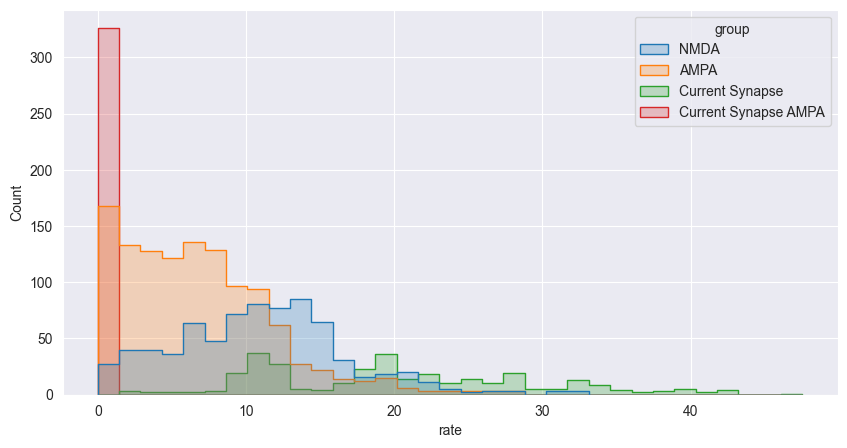

In [27]:
sns.histplot(df, x='rate', hue='group', element="step")

[Text(0.5, 1.0, 'Entropy as function of factor and rate')]

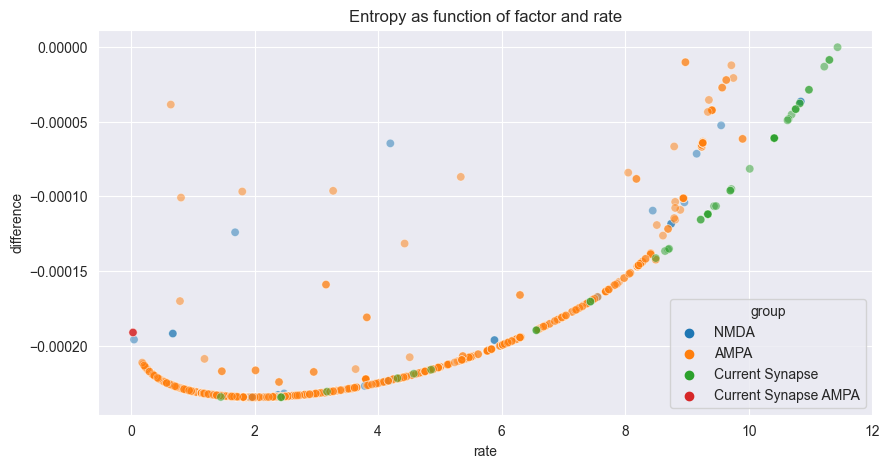

In [6]:
#maximum entropy vs the value itself
temp_df = df.copy()
temp_df['difference'] = df['normalizing_factor'] - df['entropy']
temp_df = temp_df[temp_df['difference'] < 0]
sns.scatterplot(data=temp_df, x="rate", y="difference", hue="group", sizes=(5, 200), alpha=0.5).set(
    title='Entropy as function of factor and rate')


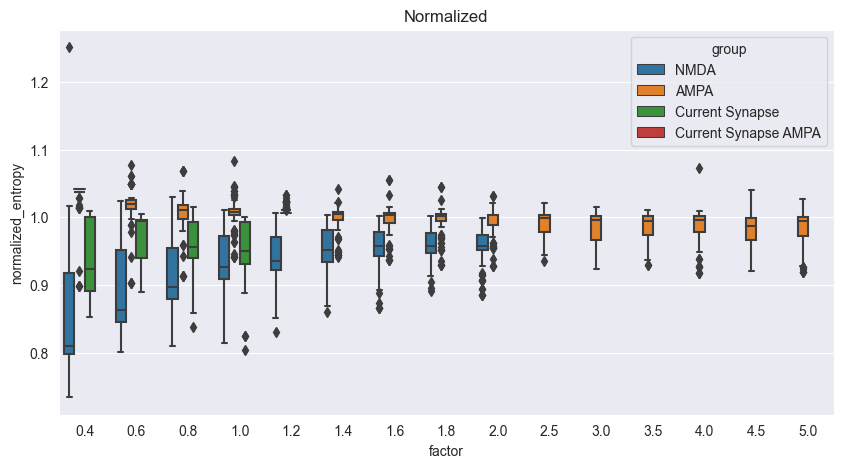

[Text(0.5, 1.0, 'Original')]

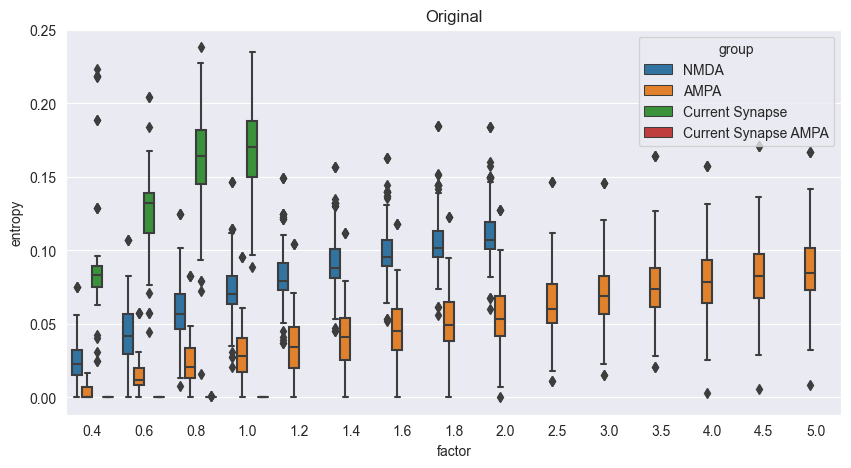

In [15]:


#show the dis

# Draw a nested boxplot to show bills by day and time

sns.boxplot(x="factor", y="normalized_entropy", data=df, hue='group').set(
    title='Normalized')  #, showmeans=True, meanprops={"marker": "o","markerfacecolor": "white","markeredgecolor": "black","markersize": "10"})

plt.show()

sns.boxplot(x="factor", y="entropy", data=df, hue='group').set(
    title='Original')  #, showmeans=True, meanprops={"marker": "o","markerfacecolor": "white","markeredgecolor": "black","markersize": "10"})



# sns.despine(offset=10, trim=True)

In [8]:
df.shape

(2567, 12)

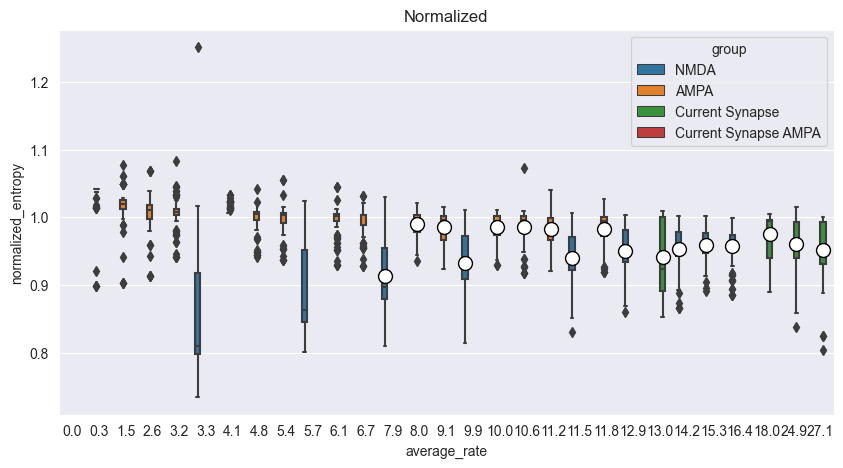

C:\Users\ninit\AppData\Local\Temp\ipykernel_13288\565351655.py:3: RuntimeWarning: divide by zero encountered in log2
  return -((1 - p) * np.log2(1 - p) + (p) * np.log2(p))
C:\Users\ninit\AppData\Local\Temp\ipykernel_13288\565351655.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return -((1 - p) * np.log2(1 - p) + (p) * np.log2(p))


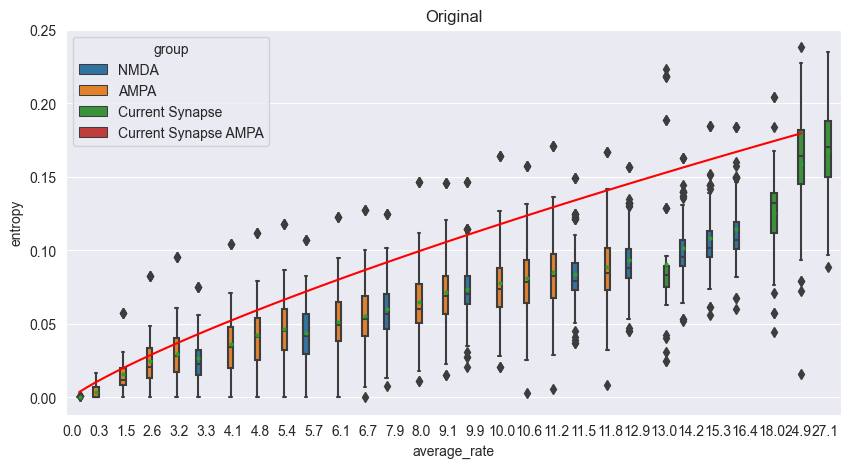

In [33]:
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="average_rate", y="normalized_entropy", data=df, hue='group', showmeans=True, meanprops={"marker": "o",
                                                                                                       "markerfacecolor": "white",
                                                                                                       "markeredgecolor": "black",
                                                                                                       "markersize": "10"}).set(
    title='Normalized')
plt.show()
x = np.linspace(df['rate'].min(), df['average_rate'].max(), 100)
l = df['l_segemnt'].mean()
# plt.plot(x,[binary_ent()(i*l,l)for i in x],color='red')
fig, ax = plt.subplots()
sns.boxplot(x="average_rate", y="entropy", data=df, showmeans=True, hue='group', meanprops={"marker": "o",
                                                                                            "markerfacecolor": "white",
                                                                                            "markeredgecolor": "black",
                                                                                            "markersize": "10"},
            ax=ax).set(title='Original')
ax.plot(x, [binary_ent(i * l / 1000., l) for i in x], color='red')


[Text(0.5, 1.0, 'Rate by factor')]

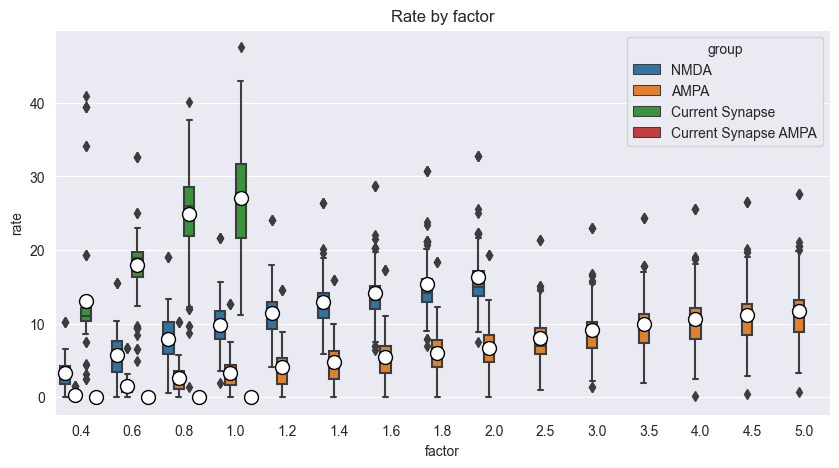

In [10]:
sns.boxplot(x="factor", y="rate", data=df, hue='group', showmeans=True, meanprops={"marker": "o",
                                                                                   "markerfacecolor": "white",
                                                                                   "markeredgecolor": "black",
                                                                                   "markersize": "10"}).set(
    title='Rate by factor')

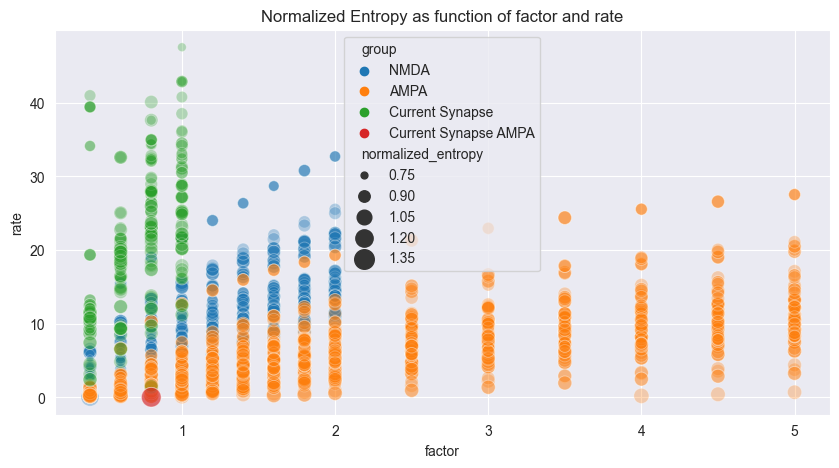

[Text(0.5, 1.0, 'Entropy as function of factor and rate')]

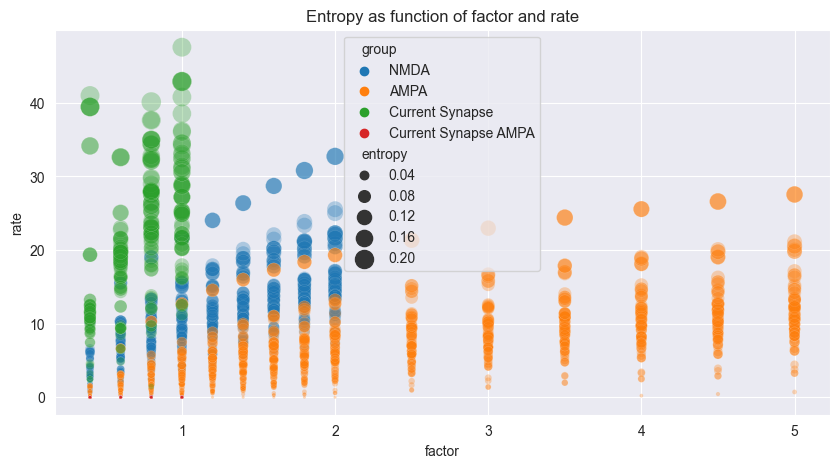

In [11]:
#factor as function of rate
temp_df = df.copy()
temp_df['normalized_entropy'] = temp_df['normalized_entropy'].apply(lambda x: float(x))
temp_df['entropy'] = temp_df['entropy'].apply(lambda x: float(x))

# temp_df['tag']=temp_df['tag'].apply(lambda x:float(x))

sns.scatterplot(data=temp_df, x="factor", y="rate", hue="group", size='normalized_entropy', sizes=(20, 200),
                alpha=0.3).set(title='Normalized Entropy as function of factor and rate')
plt.show()
sns.scatterplot(data=temp_df, x="factor", y="rate", hue="group", size='entropy', sizes=(5, 200), alpha=0.3).set(
    title='Entropy as function of factor and rate')

<AxesSubplot: xlabel='rate', ylabel='normalized_entropy'>

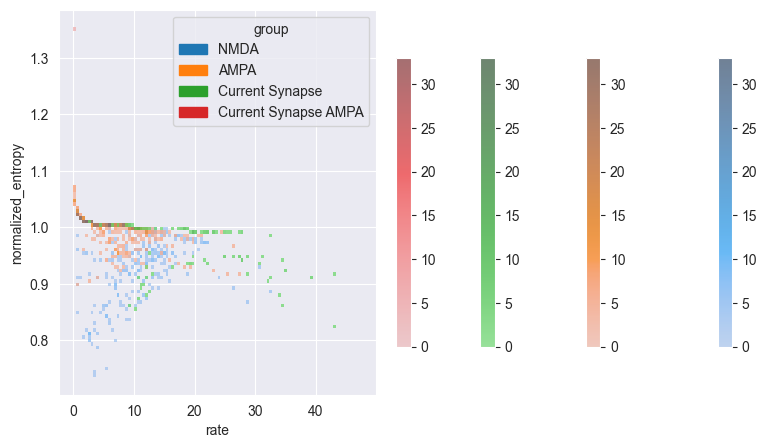

In [23]:
ax = plt.subplot()

sns.histplot(
    temp_df, x="rate", y="normalized_entropy",
    bins=100, alpha=0.7, discrete=(False, False), hue="group", log_scale=(False, False), cbar=True,
    cbar_kws=dict(shrink=.75),
    pthresh=.05, pmax=.9, ax=ax)
# plt.show()

[Text(0.5, 1.0, '$R^2$ = 0.9744198868226029')]

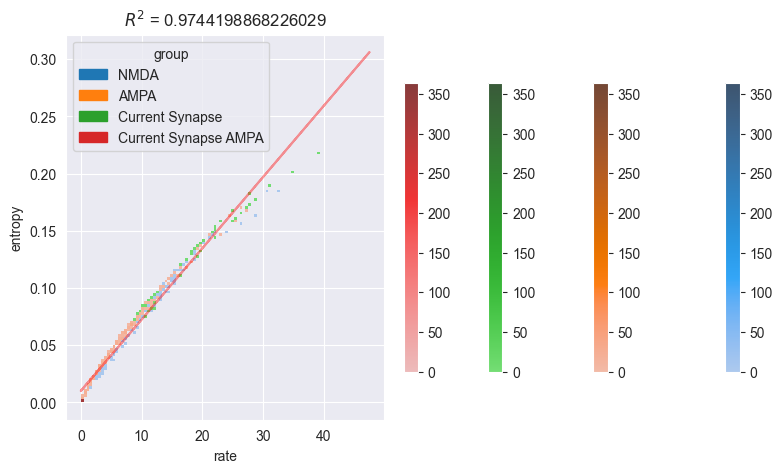

In [24]:
from sklearn import linear_model
from sklearn.metrics import r2_score

fig, ax = plt.subplots(1)
x = temp_df.rate.values[:, np.newaxis]
y = temp_df.entropy.values[:, np.newaxis]

regr = linear_model.LinearRegression()
regr.fit(x, y)
#
y_pred = regr.predict(x)
r2 = r2_score(y, y_pred)
plt.plot(x, regr.predict(x), color='red', alpha=0.4)
sns.histplot(
    temp_df, x="rate", y="entropy",
    bins=100, discrete=(False, False), hue="group", log_scale=(False, False), cbar=True, cbar_kws=dict(shrink=.75),
    pthresh=.05, pmax=.9, ax=ax).set(title='$R^2$ = ' + str(r2))
# max_val = max(temp_df['rate'].max()/1000,temp_df['entropy'].max())
# ax.plot([0,max_val*1000],[0,max_val])

# plt.xticks(())
# plt.yticks(())


In [ ]:
sns.kdeplot(data=temp_df, x="rate", y="normalized_entropy", hue="group", fill=True, log_scale=(False, False))

<h1>looking at sims<h1/>


In [ ]:
#looking at the files themselves
def create_template_series_for_model(df, full_tag, file):
    current = df[df['full_tag'] == full_tag].iloc[0].copy()
    series = pd.Series(np.nan, index=df.columns)
    series['full_tag'] = current['full_tag']
    series['factor'] = current['factor']
    series['group'] = current['group']
    series['tag'] = current['tag']
    series['average_rate'] = current['average_rate']
    series['file'] = file
    series.name = None

    return series


def fill_sims_between_all_models(df):
    models = pd.unique(df['full_tag'])
    files = pd.unique(df['file'])
    cur_df = df.copy()
    for f in files:
        for i in models:
            series = df[df['file'] == f]['full_tag'] == i
            if series.any():
                continue
            template_series = create_template_series_for_model(df, i, f)
            cur_df = cur_df.append(template_series, ignore_index=True)
    return cur_df


sorting_dict = {'Current Synapse': 0, 'AMPA': 1, 'NMDA': 2}


def sort_by_tag(x):
    # print(x)
    data = x.apply(lambda y: sorting_dict[y])
    # print(type(data))
    return data


per_sim_df = temp_df.copy()
# per_sim_df.sort_values('factor',inplace=True)
# per_sim_df.sort_values(['file','group_order','factor'],inplace=True)
# per_sim_df.sort_values(by=['file'],inplace=True)
# per_sim_df['model_id']=per_sim_df['group'].apply(lambda x:x[0])+per_sim_df['factor'].astype(str)
# g = sns.lineplot(data=per_sim_df, x='model_id', y="normalized_entropy", hue="file",legend=False)
# g._legend.remove()
# fill_sims_between_all_models(per_sim_df[per_sim_df['group'] != 'Current Synapse']).sort_values(['file', 'group', 'factor'])
per_sim_df = fill_sims_between_all_models(per_sim_df)
per_sim_df['group_order'] = per_sim_df['group'].apply(lambda x: sorting_dict[x])
per_sim_df.sort_values(['file', 'group_order', 'factor'], inplace=True)
per_sim_df.isnull().any(axis=1).sum()
#
# per_sim_df

In [ ]:
per_sim_df

In [ ]:
# per_sim_df.loc[per_sim_df['full_tag']=='Rat_L5b_PC_2_Hay_2_noNMDA_CTW','normalized_entropy']=np.nan
# per_sim_df.loc[per_sim_df['full_tag']=='Rat_L5b_PC_2_Hay_2_noNMDA_CTW',:].loc[:,'normalized_entropy']

In [ ]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

x = pd.unique(per_sim_df['full_tag'])
x_model = [per_sim_df[per_sim_df['full_tag'] == i].iloc[0]['group'] for i in x]
x_factor = [per_sim_df[per_sim_df['full_tag'] == i].iloc[0]['factor'] for i in x]
middle_points = []
cur_point = None
ax2_ticks_labels = []
fig, ax = plt.subplots(1)
for i in range(len(x_model)):
    if cur_point is None:
        cur_point = x_model[i]
        ax2_ticks_labels.append(cur_point)
    elif cur_point != x_model[i]:
        middle_points.append(i - 0.5)
        cur_point = x_model[i]
        ax2_ticks_labels.append(cur_point)
min_val = per_sim_df['normalized_entropy'].min()
max_val = per_sim_df['normalized_entropy'].max()
diff = max_val - min_val

# a = sns.lineplot(data=per_sim_df, x="full_tag", y="normalized_entropy", hue="file",legend=False,alpha=0.4,ax=ax,zorder=1)
# a.set(xticklabels=[])
# a.set_xlabel('')
for i in pd.unique(per_sim_df['file']):
    ax.plot(per_sim_df[per_sim_df['file'] == i]["full_tag"], per_sim_df[per_sim_df['file'] == i]["normalized_entropy"],
            alpha=0.4, zorder=1)
ax.set_xticklabels([])
# a.set_xlabel('')
boxes = []
for i in middle_points:
    boxes.append(Rectangle((i - 0.5, min_val), 1., max_val - min_val))
pc = PatchCollection(boxes, facecolor='white', edgecolor='white', zorder=2, alpha=0.75)
ax.add_collection(pc)
ax2_ticks = []
for i, mid in enumerate(middle_points):
    if i == 0:
        ax2_ticks.append((mid - 0.5) / 2.)
    else:
        ax2_ticks.append((mid - middle_points[i - 1]) / 2. + (middle_points[i - 1]))
    ax.vlines(mid, min_val, max_val, color='black', linewidth=2, alpha=0.8, zorder=3)
    ax.text(mid, min_val - 0.1 * diff, '|', horizontalalignment='center')
ax2_ticks.append(len(x) - (len(x) - middle_points[-1] - 0.5) / 2)
for i in range(len(ax2_ticks_labels)):
    ax.text(ax2_ticks[i], min_val - 0.2 * diff, ax2_ticks_labels[i], horizontalalignment='center')
for i in range(len(x_factor)):
    plt.text(i, min_val - 0.1 * diff, x_factor[i], horizontalalignment='center')
# ax2.set_xticks(ax2_ticks)
# ax2.set_xticklabels(ax2_ticks_labels)
plt.show()

In [ ]:
ax2_ticks, middle_points

In [ ]:
corr = temp_df[temp_df['group'] == 'NMDA'].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:

corr = temp_df[temp_df['group'] == 'AMPA'].corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
sns.histplot(data=temp_df, x="factor", y="rate", hue="group", alpha=0.7).set(
    title='Normalized Entropy as function of factor and rate')

In [ ]:
sns.scatterplot(data=temp_df, x="entropy", y="normalized_entropy", hue="group", size='rate', sizes=(5, 200), alpha=0.4)

In [ ]:
#print avarage diffs
def get_entropies_by_group(group: str):
    data_dict = dict()
    # order={k:v for v,k in enumerate(df['tag'].unique().tolist())}
    order = sorted(df['tag'].unique().tolist(), key=lambda x: float(x.replace('-', '.')))

    # temp_df = df.sort_values(by=['file'])
    for index, row in df.iterrows():
        if group != row.group:
            continue
        if row.file not in data_dict:
            data_dict[row.file] = dict()
        if row.tag not in data_dict[row.file]:
            data_dict[row.file][row.tag] = dict()

        data_dict[row.file][row.tag]['normalized'] = row.normalized_entropy
        data_dict[row.file][row.tag]['original'] = row.entropy

    normalize_arr = np.zeros((len(data_dict), len(order)))
    original_arr = np.zeros((len(data_dict), len(order)))
    x = []
    x_flag = True
    for j, d_t in enumerate(data_dict.values()):
        for i, t in enumerate(order):
            if x_flag:
                x.append(i)
            if not t in d_t:
                normalize_arr[j, i] = (np.NAN)
                original_arr[j, i] = (np.NAN)
            else:
                normalize_arr[j, i] = (d_t[t]['normalized'])
                original_arr[j, i] = (d_t[t]['original'])
        x_flag = False
    return normalize_arr, original_arr, x, order


def z_score_f(mat, ax=1):
    min_value = np.nanmin(mat, axis=ax)
    max_value = np.nanmax(mat, axis=ax)
    if ax == 1:
        min_value = min_value[:, np.newaxis]
        max_value = max_value[:, np.newaxis]
    return (mat - min_value) / (max_value - min_value)


def plot_by_group(group):
    normalize_color = np.array([0., 0., 1.])
    original_color = np.array([1., 0., 0.])

    normalize_arr, original_arr, x, order = get_entropies_by_group(group)
    fig, ax = plt.subplots(4, gridspec_kw={'height_ratios': [15, 15, 15, 1]})
    fig.suptitle(group)
    ax[0].plot(x, normalize_arr.T, c=normalize_color, alpha=0.1)
    ax[0].plot(x, original_arr.T, c=original_color, alpha=0.1)
    ax[0].set_title('entropy as function of factor')
    ax[0].set_xticks(np.arange(len(order)), order)

    ax[1].set_title('Z Score Entropy')
    ax[1].plot(x, z_score_f(normalize_arr.T, 0), c=normalize_color, alpha=0.1)
    ax[1].plot(x, z_score_f(original_arr.T, 0), c=original_color, alpha=0.1)
    ax[1].plot([], [], c=normalize_color, label='Normalized Entropy')
    ax[1].plot([], [], c=original_color, label='Entropy')
    ax[1].plot([], [], c=normalize_color / 2, label='Normalized Entropy mean')
    ax[1].plot([], [], c=original_color / 2, label='Entropy mean')
    ax[1].set_xlabel('factor')
    ax[1].set_xticks(np.arange(len(order)), order)
    ax[1].plot(x, np.nanmean(z_score_f(normalize_arr.T, ax=0), axis=1), c=normalize_color / 2,
               label='Normalized Entropy')
    ax[1].plot(x, np.nanmean(z_score_f(original_arr.T, ax=0), axis=1), c=original_color / 2, label='Entropy')

    normalize_mean = np.nanmean((normalize_arr.T), axis=1)
    original_mean = np.nanmean((original_arr.T), axis=1)
    ax[2].set_title('Derivative')
    ax[2].plot(normalize_mean[1:] - normalize_mean[:-1], c=normalize_color, label='Normalized Entropy')
    ax[2].plot(original_mean[1:] - original_mean[:-1], c=original_color, label='Entropy')
    ax[2].set_xticks([], [])
    plt.tight_layout()

    ax[3].plot([], [], c=normalize_color, label='Normalized Entropy')
    ax[3].plot([], [], c=original_color, label='Entropy')
    ax[3].legend()
    ax[3].set_xticks([], [])
    ax[3].set_yticks([], [])
    # return ax

In [ ]:
plot_by_group('NMDA')

In [ ]:
plot_by_group('AMPA')

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Profiling Report")
profile.to_widgets()

In [ ]:
profile.to_notebook_iframe()